# Postcard embeddings
the goal of this mini-project is to create image imbeddings for the postcard images, then use T-SNE to project the embeddings onto the 2-d space to create the ordering of the images

# Imports

In [4]:
# ml
from transformers import CLIPProcessor, CLIPModel
import torch.nn as nn
import torch

# data
import pandas as pd
import numpy as np

# system
import os
import sys
import requests
from pathlib import Path
from tqdm.notebook import tqdm

# image
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt

# sns.set_context(font_scale=1.5, context='paper')

# Paths

In [7]:
os.chdir('..')

In [79]:
IMAGE_DIR = Path('images')
vertical_image_dir = IMAGE_DIR / 'vertical'
horizontal_image_dir = IMAGE_DIR / 'horizontal'
large_image_dir = IMAGE_DIR / 'large'

# Load image files

In [85]:
%%time
vertical_image_paths = list(vertical_image_dir.iterdir())
vertical_images = [plt.imread(p) for p in vertical_image_paths] 

CPU times: total: 3.69 s
Wall time: 10.4 s


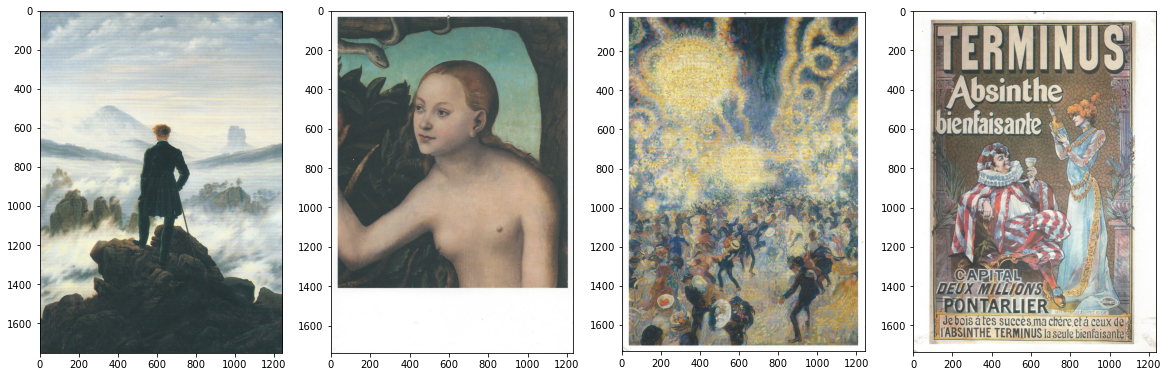

In [137]:
n = 4
base = 10
fig = plt.figure(figsize=(base * n / 2, base))
for el in range(n):
    plt.subplot(1, n, el + 1)
    plt.imshow(vertical_images[el])

In [138]:
image = vertical_images[0]
image.shape

(1752, 1243, 3)

In [108]:
# im = Image.open(vertical_image_paths[2])
# im

# Load a pretrained model

In [3]:
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

C:\Users\kostya\anaconda3\envs\ml\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\kostya\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [31]:
# model

# Preprocessing

In [32]:
processor

CLIPProcessor:
- feature_extractor: CLIPFeatureExtractor {
  "crop_size": 224,
  "do_center_crop": true,
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_resize": true,
  "feature_extractor_type": "CLIPFeatureExtractor",
  "image_mean": [
    0.48145466,
    0.4578275,
    0.40821073
  ],
  "image_std": [
    0.26862954,
    0.26130258,
    0.27577711
  ],
  "resample": 3,
  "size": 224
}

- tokenizer: PreTrainedTokenizerFast(name_or_path='openai/clip-vit-large-patch14', vocab_size=49408, model_max_len=77, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': AddedToken("<|startoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'eos_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'unk_token': AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True), 'pad_token': '<|endoftext|>'})

In [160]:
inputs = processor(
    images=vertical_images,
    return_tensors="pt", 
    padding=True
)
inputs['pixel_values'].shape

torch.Size([63, 3, 224, 224])

## check

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


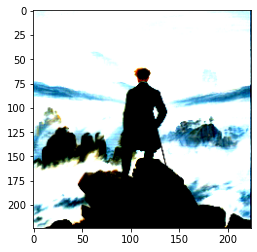

In [161]:
out = inputs['pixel_values'][0].numpy().squeeze().transpose(1, 2, 0)
plt.imshow(out)

# Get the last layer hidden state from the vision model

In [64]:
# model

In [63]:
def count_parameters(model):
    """Returns number of model params"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

f"{count_parameters(model.vision_model):.4e} weights"

'3.0318e+08 weights'

In [149]:
# model to cuda
device = 'cuda'
vision_model = model.vision_model
vision_model = vision_model.to(device)

In [162]:
# images to cuda
inputs['pixel_values'] = inputs['pixel_values'].to(device)

In [163]:
%%time
vision_outputs = vision_model(**inputs)
vision_outputs

RuntimeError: CUDA out of memory. Tried to allocate 254.00 MiB (GPU 0; 6.00 GiB total capacity; 5.15 GiB already allocated; 0 bytes free; 5.18 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [153]:
%%time
visual_projection = model.visual_projection.to(device)
last_hidden_state_proj = visual_projection(vision_outputs.last_hidden_state)

CPU times: total: 0 ns
Wall time: 15 ms


In [154]:
last_hidden_state_proj.shape

torch.Size([1, 257, 768])